## Train TF model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
path_to_faces_ark = tf.keras.utils.get_file('faces.tgz', origin='http://vis-www.cs.umass.edu/lfw/lfw.tgz', extract=True)
path_to_faces = os.path.join(os.path.dirname(path_to_faces_ark), 'lfw')

In [23]:
face_files = [f for f in glob(path_to_faces+'/**/*.jpg', recursive=True)]

face_images = np.array([
    np.array(tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32), interpolation='bicubic'))
    for image_path in face_files
])

face_labels = np.ones(face_images.shape[0], dtype=int)
face_images.shape

(13233, 32, 32, 3)

In [24]:
(cifar_img_train, _), (_, _) = keras.datasets.cifar10.load_data()
cifar_images = cifar_img_train

cifar_labels = np.zeros(cifar_images.shape[0], dtype=int)
cifar_images.shape

(50000, 32, 32, 3)

In [25]:
images = np.concatenate((face_images, cifar_images))
images = images / 255.0
images = tf.image.rgb_to_grayscale(images).numpy()
images = np.reshape(images, (-1, 32,32,1))

labels = np.concatenate((face_labels, cifar_labels))

img_train, img_test, label_train, label_test = train_test_split(images, labels, random_state=1234, stratify=labels)

pd.DataFrame.from_records([
  ["Train", img_train.shape[0], np.count_nonzero(label_train)],
  ["Test", img_test.shape[0], np.count_nonzero(label_test)],
], columns = ["Dataset", "Size", "Positive labels"], index="Dataset")

,Size,Positive labels
Dataset,,
Train,47424,9925
Test,15809,3308


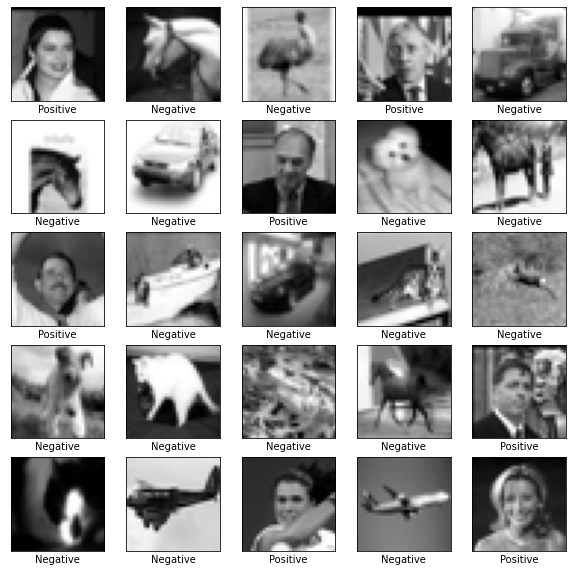

In [26]:
lbls = ['Negative', 'Positive']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[i].reshape((32,32)), cmap='gray')
    plt.xlabel(lbls[label_train[i]])
plt.show()

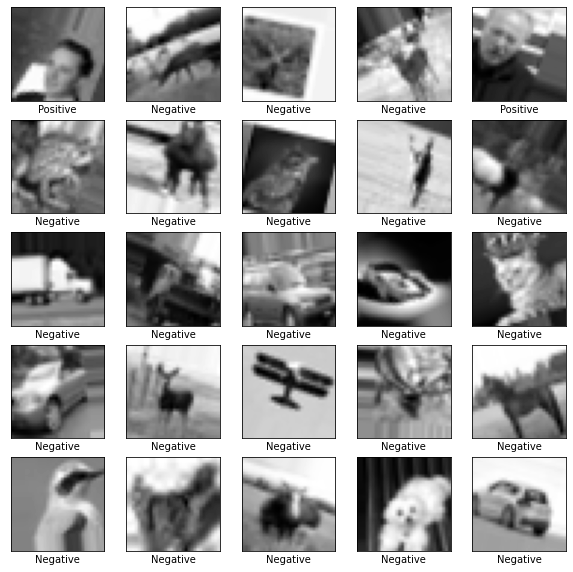

In [49]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_data_generator = image_generator.flow(img_train, label_train)

train, label = next(train_data_generator)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i].reshape((32,32)), cmap='gray')
    plt.xlabel(lbls[label[i]])
plt.show()

In [28]:
model = keras.Sequential([
    keras.layers.Conv2D(16, 3, activation='relu', input_shape=(32, 32, 1)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)         

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    image_generator.flow(img_train, label_train), epochs=10,
    validation_data=(img_test, label_test))

Epoch 1/10
1482/1482 [==============================] - 17s 11ms/step - loss: 0.3813 - accuracy: 0.8778 - val_loss: 0.1282 - val_accuracy: 0.9595
Epoch 2/10
1482/1482 [==============================] - 16s 11ms/step - loss: 0.1340 - accuracy: 0.9483 - val_loss: 0.0734 - val_accuracy: 0.9756
Epoch 3/10
1482/1482 [==============================] - 16s 11ms/step - loss: 0.0935 - accuracy: 0.9667 - val_loss: 0.0442 - val_accuracy: 0.9871
Epoch 4/10
1482/1482 [==============================] - 17s 11ms/step - loss: 0.0770 - accuracy: 0.9728 - val_loss: 0.0498 - val_accuracy: 0.9845
Epoch 5/10
1482/1482 [==============================] - 16s 11ms/step - loss: 0.0717 - accuracy: 0.9741 - val_loss: 0.0453 - val_accuracy: 0.9860
Epoch 6/10
1482/1482 [==============================] - 16s 11ms/step - loss: 0.0634 - accuracy: 0.9787 - val_loss: 0.0345 - val_accuracy: 0.9891
Epoch 7/10
1482/1482 [==============================] - 17s 11ms/step - loss: 0.0595 - accuracy: 0.9786 - val_loss: 0.0341 -

495/495 [==============================] - 1s 2ms/step - loss: 0.0402 - accuracy: 0.9880


(0.040151290595531464, 0.988044798374176)

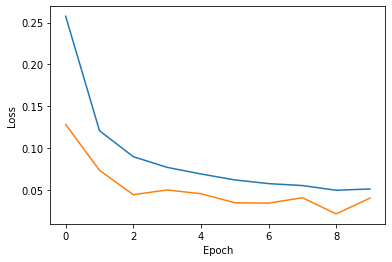

In [53]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

test_loss, test_acc = model.evaluate(img_test, label_test)
test_loss, test_acc

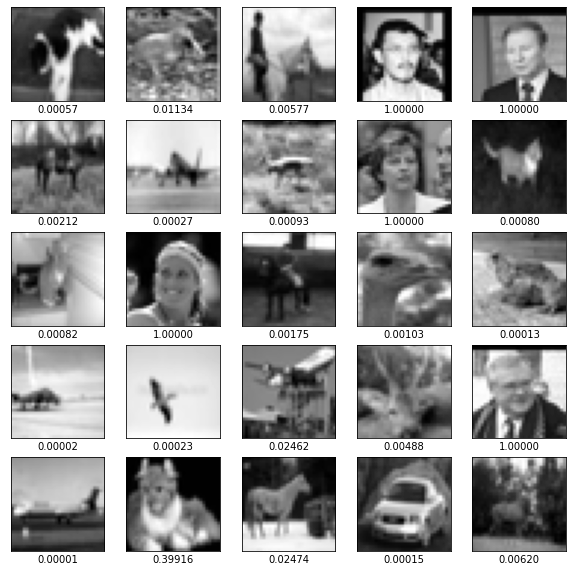

In [54]:
predictions = model.predict(img_test)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_test[i].reshape((32,32)), cmap='gray')
    plt.xlabel(f'{float(predictions[i]):.5f}')
plt.show()

In [55]:
saved_model_dir = 'face_model'
model.save(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(f'{saved_model_dir}.tflite', 'wb') as f:
  f.write(tflite_model)

optimized_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
optimized_converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
  for data in img_train[:100]:
    yield [np.array([data], dtype=np.float32)]

optimized_converter.representative_dataset = representative_dataset_gen
optimized_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
optimized_converter.inference_input_type = tf.int8 
optimized_converter.inference_output_type = tf.int8 
optimized_tflite_model = optimized_converter.convert()

with open(f'{saved_model_dir}_optimized.tflite', 'wb') as f:
  f.write(optimized_tflite_model)

INFO:tensorflow:Assets written to: face_model/assets


INFO:tensorflow:Assets written to: face_model/assets


In [56]:
size_tf = sum([os.path.getsize(os.path.join(path, f)) for path, dirs, files in os.walk(saved_model_dir) for f in files])
size_tflite = os.path.getsize(f'{saved_model_dir}.tflite')
size_tflite_optimized = os.path.getsize(f'{saved_model_dir}_optimized.tflite')

pd.DataFrame.from_records([
  ["Tensorflow", f'{size_tf/1024:.2f}kB'],
  ["Tensorflow Lite", f'{size_tflite/1024:.2f}kB'],
  ["Tensorflow Lite Optimized", f'{size_tflite_optimized/1024:.2f}kB'],
], columns = ["Model", "Size"], index="Model")

,Size
Model,
Tensorflow,789.03kB
Tensorflow Lite,202.07kB
Tensorflow Lite Optimized,56.52kB


In [57]:
!apt-get update && apt-get -qq install xxd

!xxd -i {saved_model_dir}_optimized.tflite > {saved_model_dir}.cc
!cat {saved_model_dir}.cc

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
unsigned char face_model_optim

## Inspect TF Lite Model

In [69]:
interpreter = tf.lite.Interpreter(model_path='face_model_optimized.tflite')
input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]


pd.DataFrame.from_records([
  ["Input", str(input['dtype']), input['quantization'][0], input['quantization'][1]],
  ["Output", str(output['dtype']), output['quantization'][0], output['quantization'][1]],
], columns = ["Details", "Type", "Scale", "Zero Point"], index="Details")

,Type,Scale,Zero Point
Details,,,
Input,<class 'numpy.int8'>,0.003921,-128
Output,<class 'numpy.int8'>,0.003906,-128
